In [1]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, arch_scan, get_data, get_data_softDrop
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135
rng3 = 34530
rng4 = 20461

2023-07-10 18:14:39.013631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Quark jets, R = 0.8

In [2]:
hdata = get_data('q',hlevel=True,efrac=False)[:100000]
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('q',hlevel=False,efrac=False)[:100000]
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng3)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng4)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

2023-07-10 00:02:08.288108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 00:02:08.657291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 00:02:08.657688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 00:02:08.674007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2023-07-10 00:02:13.076412: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


782/782 [==============================] - 7s 6ms/step - loss: 0.6693 - acc: 0.5596 - val_loss: 0.6594 - val_acc: 0.5808
Epoch 2/100
782/782 [==============================] - 5s 6ms/step - loss: 0.6326 - acc: 0.6136 - val_loss: 0.6223 - val_acc: 0.6237
Epoch 3/100
782/782 [==============================] - 4s 6ms/step - loss: 0.6048 - acc: 0.6464 - val_loss: 0.5815 - val_acc: 0.6708
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 0.5796 - acc: 0.6744 - val_loss: 0.5598 - val_acc: 0.6944
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 0.5631 - acc: 0.6892 - val_loss: 0.5496 - val_acc: 0.7046
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 0.5492 - acc: 0.7008 - val_loss: 0.5367 - val_acc: 0.7107
Epoch 7/100
782/782 [==============================] - 4s 5ms/step - loss: 0.5365 - acc: 0.7127 - val_loss: 0.5158 - val_acc: 0.7275
Epoch 8/100
782/782 [==============================] - 4s 5ms/step - loss: 0.5279

3065

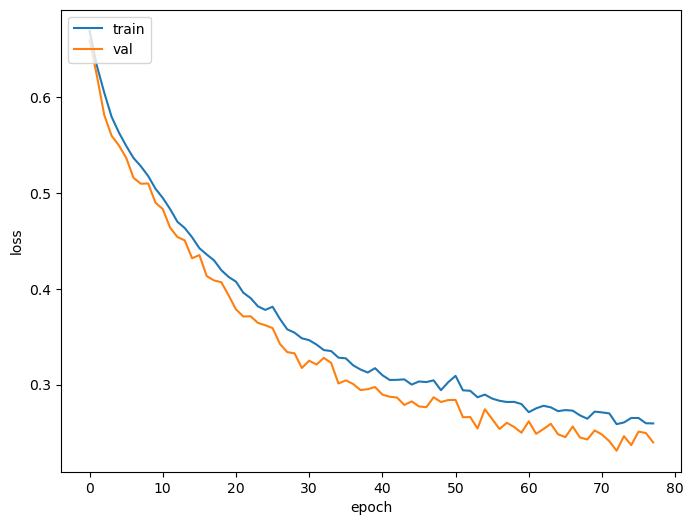

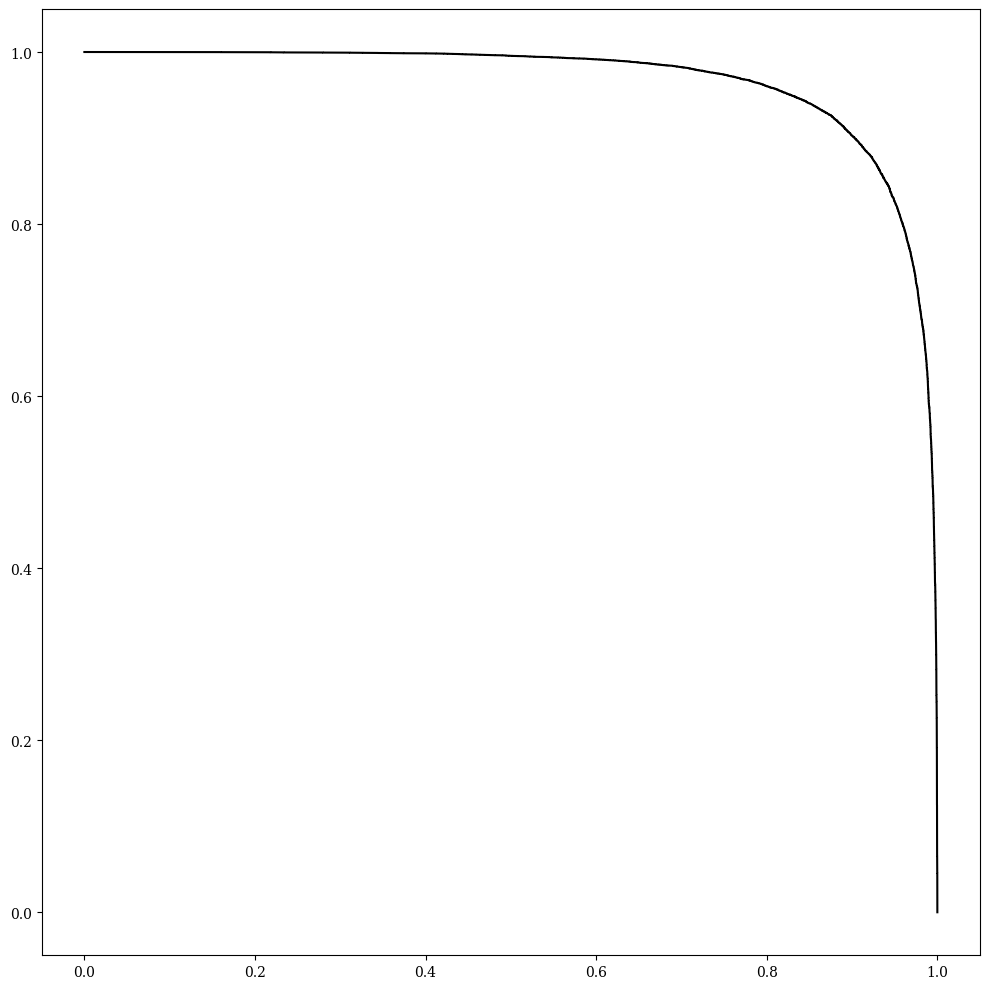

In [3]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":5,
                "optimizer":Adam(1e-3),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":100,"verbose":1,"batch_size":128}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save("keras_models/qjet_EFN_zpT_iter10.keras")
del efn
gc.collect()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation_35 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_35[0][0]']          
                                                                                            

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
10/10 [==============================] - 5s 292ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 3s 265ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 2s 240ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/100
10/10 [==============================] - 2s 240ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/100
10/10 [==============================] - 2s 242ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/100
10/10 [==============================] - 2s 240ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/100
10/10 [==============================] - 2s 241ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/100
10/10 [==============================] - 2s 242ms/step - 

2634

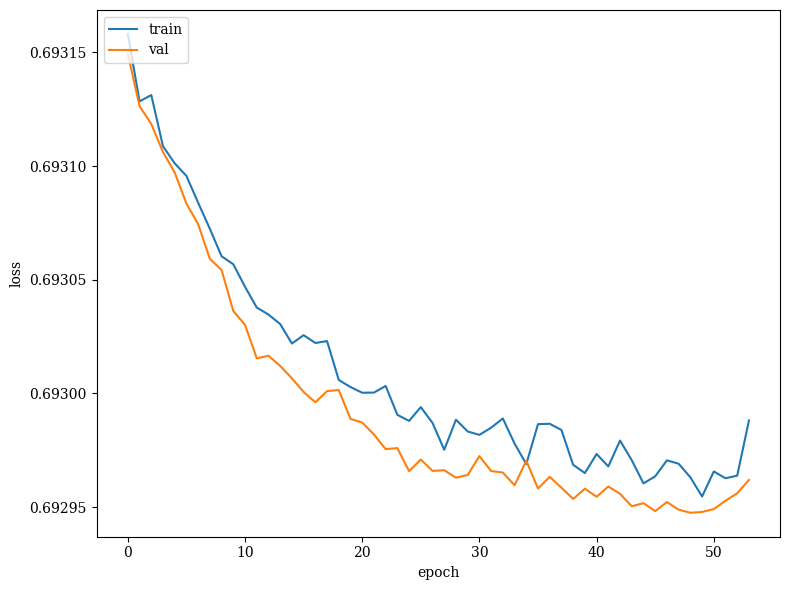

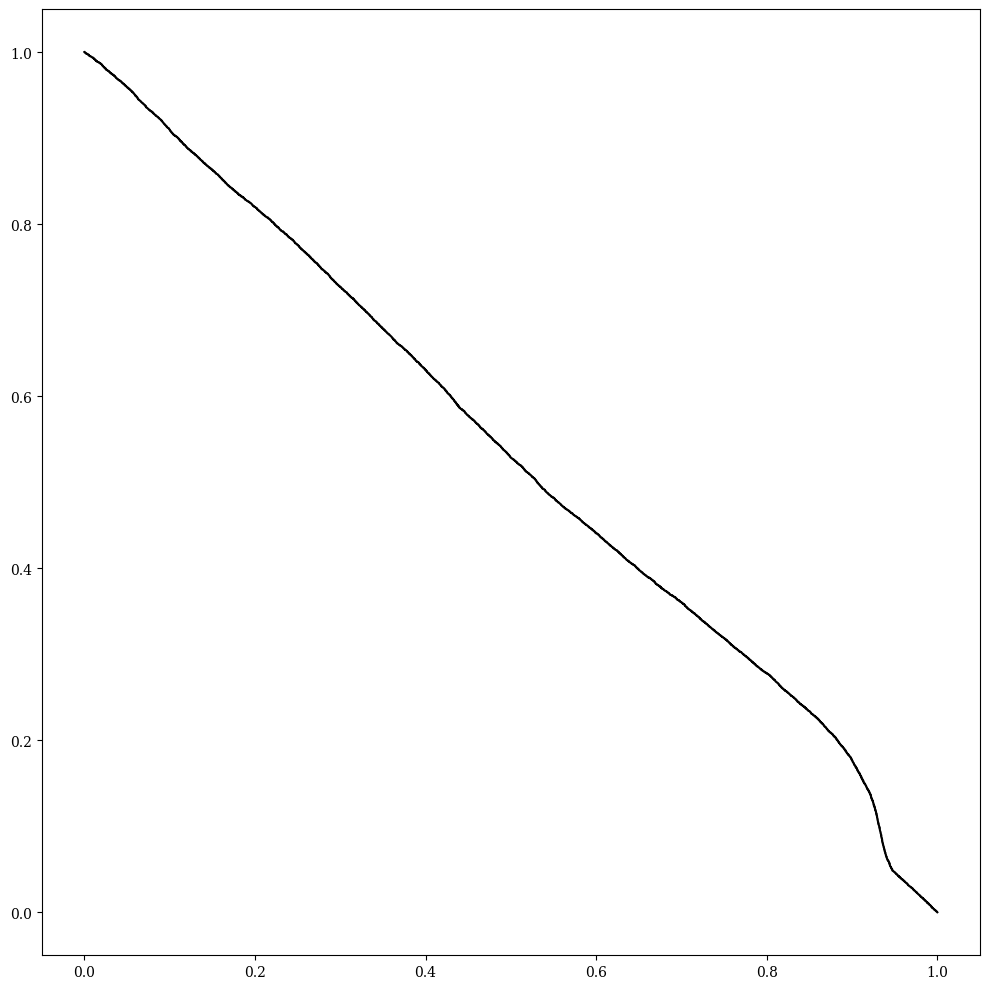

In [8]:
# EFN with spectral normalization
loss = BinaryCrossentropy(from_logits=True)
out_act = keras.activations.linear
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":out_act,
                "patience":5,
                "optimizer":Adam(5e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":100,"verbose":1,"batch_size":10000}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models/qjet_spectralEFN_zpT_iter10.keras")
del efn
gc.collect()

# Gluon jets, R = 0.8

In [2]:
hdata = get_data('g',hlevel=True,efrac=False)[:100000]
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=False)[:100000]
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng3)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng4)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation_35 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation_35[0][0]']          
                                                                                            

2381

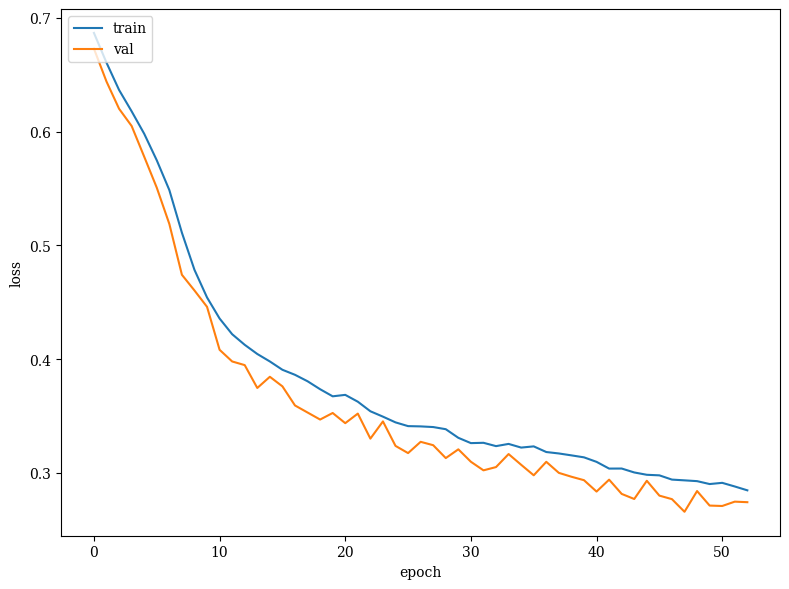

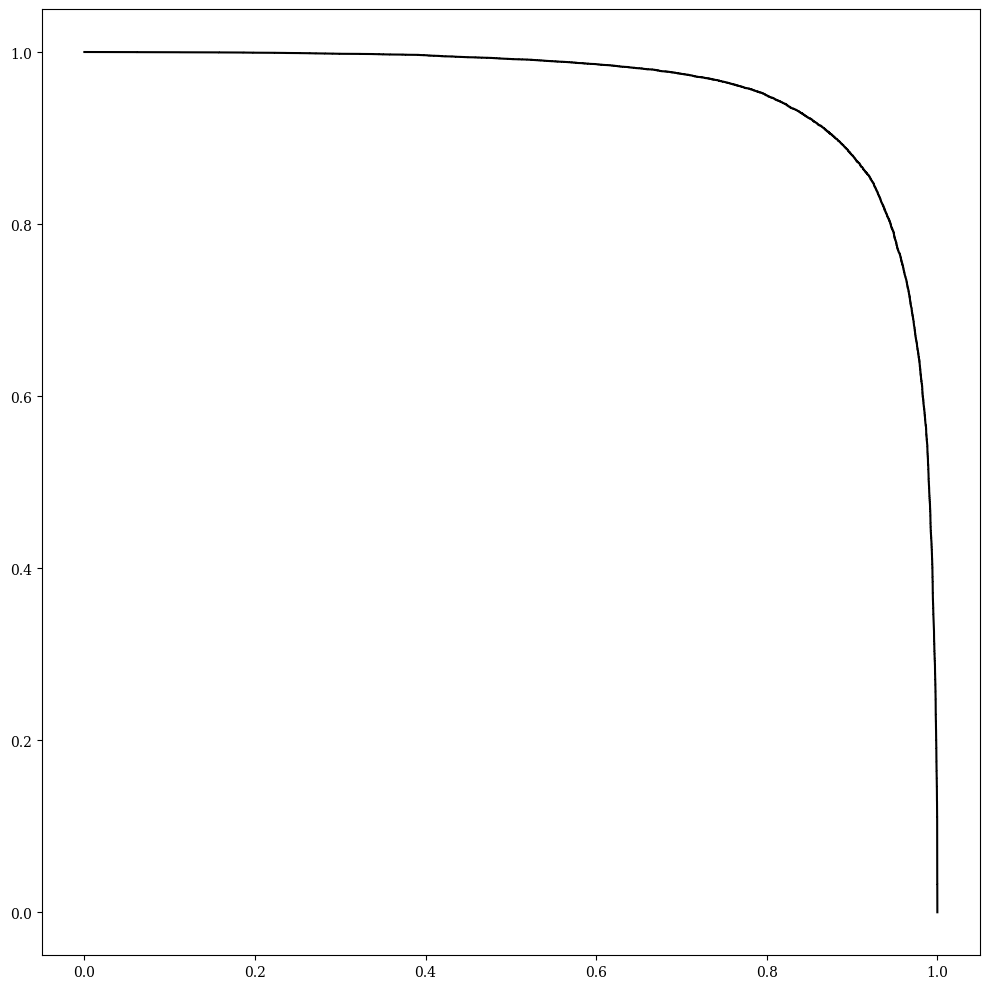

In [9]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":5,
                "optimizer":Adam(1e-3),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":100,"verbose":1,"batch_size":128}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn_name = "keras_models/gjet_EFN_zpT_iter10.keras"
efn.save(efn_name)
del efn
gc.collect()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation_112 (Activation)    (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_112[0][0]']         
                                                                                           

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
10/10 [==============================] - 5s 281ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 2s 239ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 2s 234ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/100
10/10 [==============================] - 2s 235ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/100
10/10 [==============================] - 2s 235ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/100
10/10 [==============================] - 2s 236ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/100
10/10 [==============================] - 2s 233ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/100
10/10 [==============================] - 2s 235ms/step - 

2634

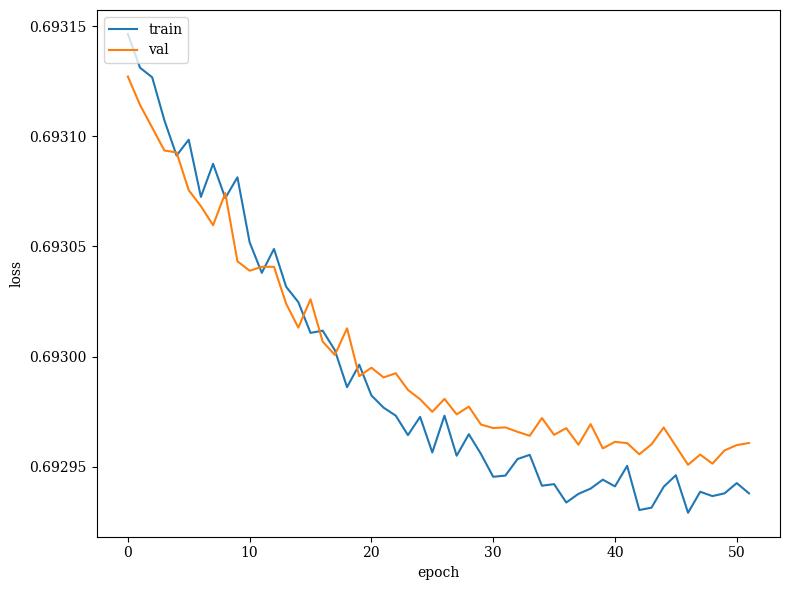

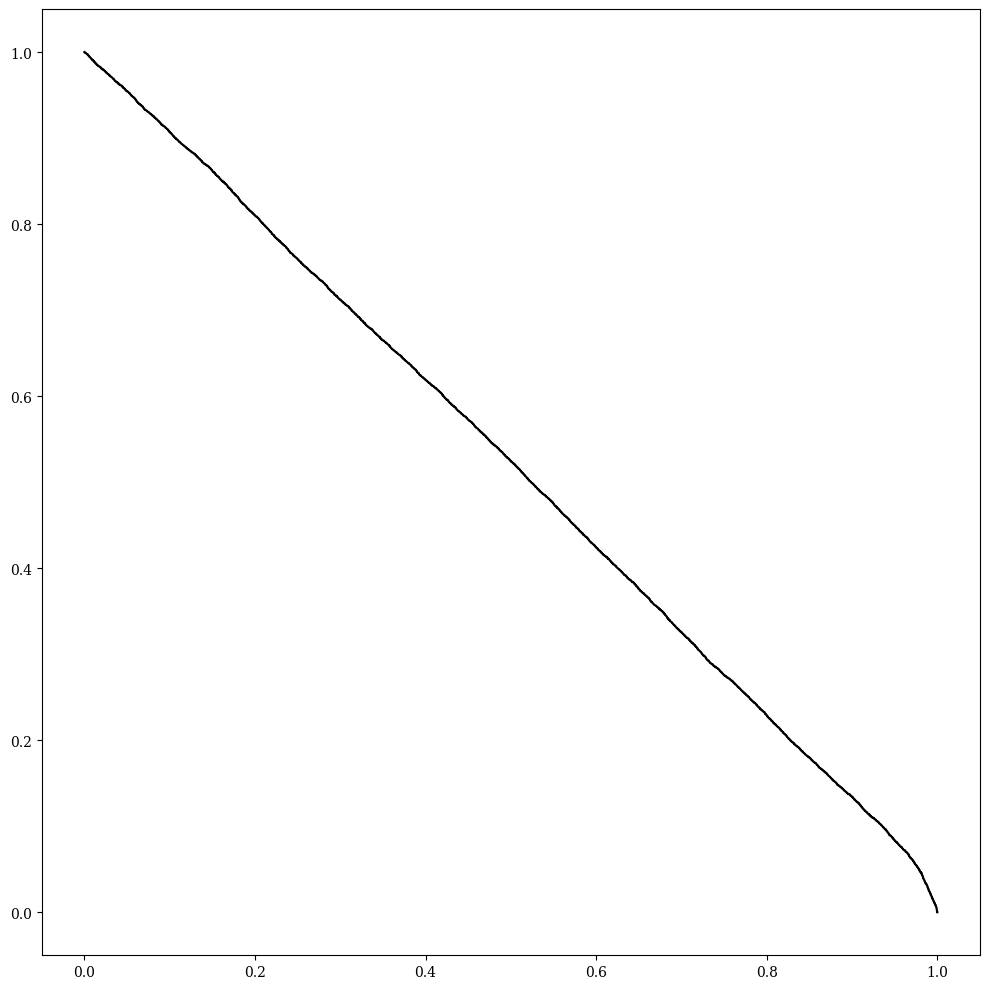

In [20]:
# EFN with spectral normalization
loss = BinaryCrossentropy(from_logits=True)
out_act = keras.activations.linear
model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":out_act,
                "patience":5,
                "optimizer":Adam(5e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":100,"verbose":1,"batch_size":10000}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models/gjet_spectralEFN_zpT_iter10.keras")
del efn
gc.collect()